# Big Data Analysis


## Part 1 feature engineering and feature selection

In [237]:
import pandas as  pd
import numpy as np

import datetime
import shap
import eli5
import seaborn as sns
import matplotlib.pyplot as plt

from mvtpy import mvtest
from wordcloud import WordCloud
from scipy import stats
from eli5.sklearn import PermutationImportance
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

from typing import *
import warnings 
warnings.filterwarnings('ignore')

In [238]:
# total label
labels = ['total_purchase_amt','total_redeem_amt']
date_indexs = ['week','year','month','weekday','day']
low_corr=[]
low_sep=[]


In [239]:
# Load the balance data
def load_data(path: str = 'user_balance_table.csv')->pd.DataFrame:
    data_balance = pd.read_csv(path)
    return data_balance.reset_index(drop=True)
    

# add tiemstamp to dataset
def add_timestamp(data: pd.DataFrame, time_index: str = 'report_date')->pd.DataFrame:
    data_balance = data.copy()
    data_balance['date'] = pd.to_datetime(data_balance[time_index], format= "%Y%m%d")
    data_balance['day'] = data_balance['date'].dt.day
    data_balance['month'] = data_balance['date'].dt.month
    data_balance['year'] = data_balance['date'].dt.year
    data_balance['week'] = data_balance['date'].dt.week
    data_balance['weekday'] = data_balance['date'].dt.weekday
    return data_balance.reset_index(drop=True)

# total amount
def get_total_balance(data: pd.DataFrame, date: str = '2014-03-31')->pd.DataFrame:
    df_tmp = data.copy()
    df_tmp = df_tmp.groupby(['date'])['total_purchase_amt','total_redeem_amt'].sum()
    df_tmp.reset_index(inplace=True)
    return df_tmp[(df_tmp['date']>= date)].reset_index(drop=True)

# Generate the test data
def generate_test_data(data: pd.DataFrame)->pd.DataFrame:
    total_balance = data.copy()
    start = datetime.datetime(2014,9,1)
    testdata = []
    while start != datetime.datetime(2014,10,15):
        temp = [start, np.nan, np.nan]
        testdata.append(temp)
        start += datetime.timedelta(days = 1)
    testdata = pd.DataFrame(testdata)
    testdata.columns = total_balance.columns

    total_balance = pd.concat([total_balance, testdata], axis = 0)
    total_balance = total_balance.reset_index(drop=True)
    return total_balance.reset_index(drop=True)

# Load user's information
def load_user_information(path: str = 'user_profile_table.csv')->pd.DataFrame:
    return pd.read_csv(path)

In [240]:
# read the raw data
balance_data = load_data('data/base.csv')
balance_data = add_timestamp(balance_data, time_index='date')
total_balance = get_total_balance(balance_data)
total_balance = generate_test_data(total_balance)
total_balance = add_timestamp(total_balance, 'date')
total_balance.dropna(inplace=True)



## 1.1 Feature extracting

### (1) Dummy features

In [241]:
# holiday information

def get_holiday_set()->Set[datetime.date]:
    holiday_set = set()
    # The Qingming Festival
    holiday_set = holiday_set | {datetime.date(2014,4,5), datetime.date(2014,4,6), datetime.date(2014,4,7)}
    # The Labor Day
    holiday_set = holiday_set | {datetime.date(2014,5,1), datetime.date(2014,5,2), datetime.date(2014,5,3)}
    # The Dragon Boat Festival
    holiday_set = holiday_set | {datetime.date(2014,5,31), datetime.date(2014,6,1), datetime.date(2014,6,2)}
    # The Mid-Autumn Festival
    holiday_set = holiday_set | {datetime.date(2014,9,6), datetime.date(2014,9,7), datetime.date(2014,9,8)}
    # The National Day
    holiday_set = holiday_set | {datetime.date(2014,10,1), datetime.date(2014,10,2), datetime.date(2014,10,3),\
                                 datetime.date(2014,10,4), datetime.date(2014,10,5), datetime.date(2014,10,6),\
                                datetime.date(2014,10,7)}
    # The Mid-Autumn Festival
    holiday_set = holiday_set | {datetime.date(2013,9,19), datetime.date(2013,9,20), datetime.date(2013,9,21)}
    # The National Day
    holiday_set = holiday_set | {datetime.date(2013,10,1), datetime.date(2013,10,2), datetime.date(2013,10,3),\
                                 datetime.date(2013,10,4), datetime.date(2013,10,5), datetime.date(2013,10,6),\
                                datetime.date(2013,10,7)}
    return holiday_set



def extract_is_feature(data: pd.DataFrame)->pd.DataFrame:
    total_balance = data.copy().reset_index(drop=True)
    
    # is_weekend
    total_balance['is_weekend'] = 0
    total_balance.loc[total_balance['weekday'].isin((5,6)), 'is_weekend'] = 1
    
    # is_holiday
    total_balance['is_holiday'] = 0
    total_balance.loc[total_balance['date'].isin(get_holiday_set()), 'is_holiday'] = 1
    
    # is_firstday_of_holiday
    last_day_flag = 0
    total_balance['is_firstday_of_holiday'] = 0
    for index, row in total_balance.iterrows():
        if last_day_flag == 0 and row['is_holiday'] == 1:
            total_balance.loc[index, 'is_firstday_of_holiday'] = 1
        last_day_flag = row['is_holiday']

    # is_lastday_of_holiday
    total_balance['is_lastday_of_holiday'] = 0
    for index, row in total_balance.iterrows():
        if row['is_holiday'] == 1 and total_balance.loc[index+1, 'is_holiday'] == 0:
             total_balance.loc[index, 'is_lastday_of_holiday'] = 1

    # is_firstday_of_work
    total_balance['is_firstday_of_work'] = 0
    last_day_flag = 0
    for index, row in total_balance.iterrows():
        if last_day_flag == 1 and row['is_holiday'] == 0:
            total_balance.loc[index, 'is_firstday_of_work'] = 1
        last_day_flag = row['is_lastday_of_holiday']

    # is_work
    total_balance['is_work'] = 1
    total_balance.loc[(total_balance['is_holiday'] == 1) | (total_balance['is_weekend'] == 1), 'is_work'] = 0
    special_work_day_set = {datetime.date(2014,5,4), datetime.date(2014,9,28)}
    total_balance.loc[total_balance['date'].isin(special_work_day_set), 'is_work'] = 1

    # is_gonna_work_tomorrow
    total_balance['is_gonna_work_tomorrow'] = 0
    for index, row in total_balance.iterrows():
        if index == len(total_balance)-1:
            break
        if row['is_work'] == 0 and total_balance.loc[index+1, 'is_work'] == 1:
             total_balance.loc[index, 'is_gonna_work_tomorrow'] = 1

    # is_worked_yestday
    total_balance['is_worked_yestday'] = 0
    for index, row in total_balance.iterrows():
        if index <= 1:
            continue
        if total_balance.loc[index-1, 'is_work'] == 1:
             total_balance.loc[index, 'is_worked_yestday'] = 1

    # is_lastday_of_workday
    total_balance['is_lastday_of_workday'] = 0
    for index, row in total_balance.iterrows():
        if index == len(total_balance)-1:
            break
        if row['is_holiday'] == 0 and total_balance.loc[index+1, 'is_holiday'] == 1:
             total_balance.loc[index, 'is_lastday_of_workday'] = 1

    # is_work_on_sunday
    total_balance['is_work_on_sunday'] = 0
    for index, row in total_balance.iterrows():
        if index == len(total_balance)-1:
            break
        if row['weekday'] == 6 and row['is_work'] == 1:
             total_balance.loc[index, 'is_work_on_sunday'] = 1
                
    # is_firstday_of_month
    total_balance['is_firstday_of_month'] = 0
    total_balance.loc[total_balance['day'] == 1, 'is_firstday_of_month'] = 1

    # is_secday_of_month
    total_balance['is_secday_of_month'] = 0
    total_balance.loc[total_balance['day'] == 2, 'is_secday_of_month'] = 1

    # is_premonth
    total_balance['is_premonth'] = 0
    total_balance.loc[total_balance['day'] <= 10, 'is_premonth'] = 1

    # is_midmonth
    total_balance['is_midmonth'] = 0
    total_balance.loc[(10 < total_balance['day']) & (total_balance['day'] <= 20), 'is_midmonth'] = 1

    # is_tailmonth
    total_balance['is_tailmonth'] = 0
    total_balance.loc[20 < total_balance['day'], 'is_tailmonth'] = 1

    # is_first_week
    total_balance['is_first_week'] = 0
    total_balance.loc[total_balance['week'] % 4 == 1, 'is_first_week'] = 1

    # is_second_week
    total_balance['is_second_week'] = 0
    total_balance.loc[total_balance['week'] % 4 == 2, 'is_second_week'] = 1

    # is_third_week
    total_balance['is_third_week'] = 0
    total_balance.loc[total_balance['week'] % 4 == 3, 'is_third_week'] = 1

    # is_fourth_week
    total_balance['is_fourth_week'] = 0
    total_balance.loc[total_balance['week'] % 4 == 0, 'is_fourth_week'] = 1
    
    return total_balance.reset_index(drop=True)


#Encode next day features to dataset
def encode_data(data: pd.DataFrame, feature_name:str = 'weekday', encoder=OneHotEncoder())->pd.DataFrame():
    total_balance = data.copy()
    week_feature = encoder.fit_transform(np.array(total_balance[feature_name]).reshape(-1, 1)).toarray()
    week_feature = pd.DataFrame(week_feature,columns= [feature_name + '_onehot_'+ str(x) for x in range(len(week_feature[0]))])
    #featureWeekday = pd.concat([total_balance, week_feature], axis = 1).drop(feature_name, axis=1)
    featureWeekday = pd.concat([total_balance, week_feature], axis = 1)
    return featureWeekday



In [242]:
# Extract dummy features to dataset

total_balance = extract_is_feature(total_balance)
total_balance = encode_data(total_balance)
feature = total_balance[[x for x in total_balance.columns if x not in date_indexs]]

In [243]:
feature

,date,total_purchase_amt,total_redeem_amt,is_weekend,is_holiday,is_firstday_of_holiday,is_lastday_of_holiday,is_firstday_of_work,is_work,is_gonna_work_tomorrow,...,is_second_week,is_third_week,is_fourth_week,weekday_onehot_0,weekday_onehot_1,weekday_onehot_2,weekday_onehot_3,weekday_onehot_4,weekday_onehot_5,weekday_onehot_6
0,2014-03-31,0.000000,0.000000,0,0,0,0,0,1,0,...,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-04-01,0.730303,0.634370,0,0,0,0,0,1,0,...,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2014-04-02,0.818276,0.761724,0,0,0,0,0,1,0,...,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2014-04-03,0.768604,0.703255,0,0,0,0,0,1,0,...,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2014-04-04,0.680148,0.926145,0,0,0,0,0,1,0,...,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2014-10-10,0.000000,0.000000,0,0,0,0,0,1,0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
194,2014-10-11,0.000000,0.000000,1,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
195,2014-10-12,0.000000,0.000000,1,0,0,0,0,0,1,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
196,2014-10-13,0.000000,0.000000,0,0,0,0,0,1,0,...,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### (2) Dummy feature selection

In [244]:
# draw box graph
def draw_boxplot(data: pd.DataFrame)->None:
    f, axes = plt.subplots(7, 4, figsize=(18, 24))
    global date_indexs, labels
    count = 0
    for i in [x for x in data.columns if x not in date_indexs + labels + ['date']]:
        sns.boxenplot(x=i, y='total_purchase_amt', data=data, ax=axes[count // 4][count % 4])
        count += 1

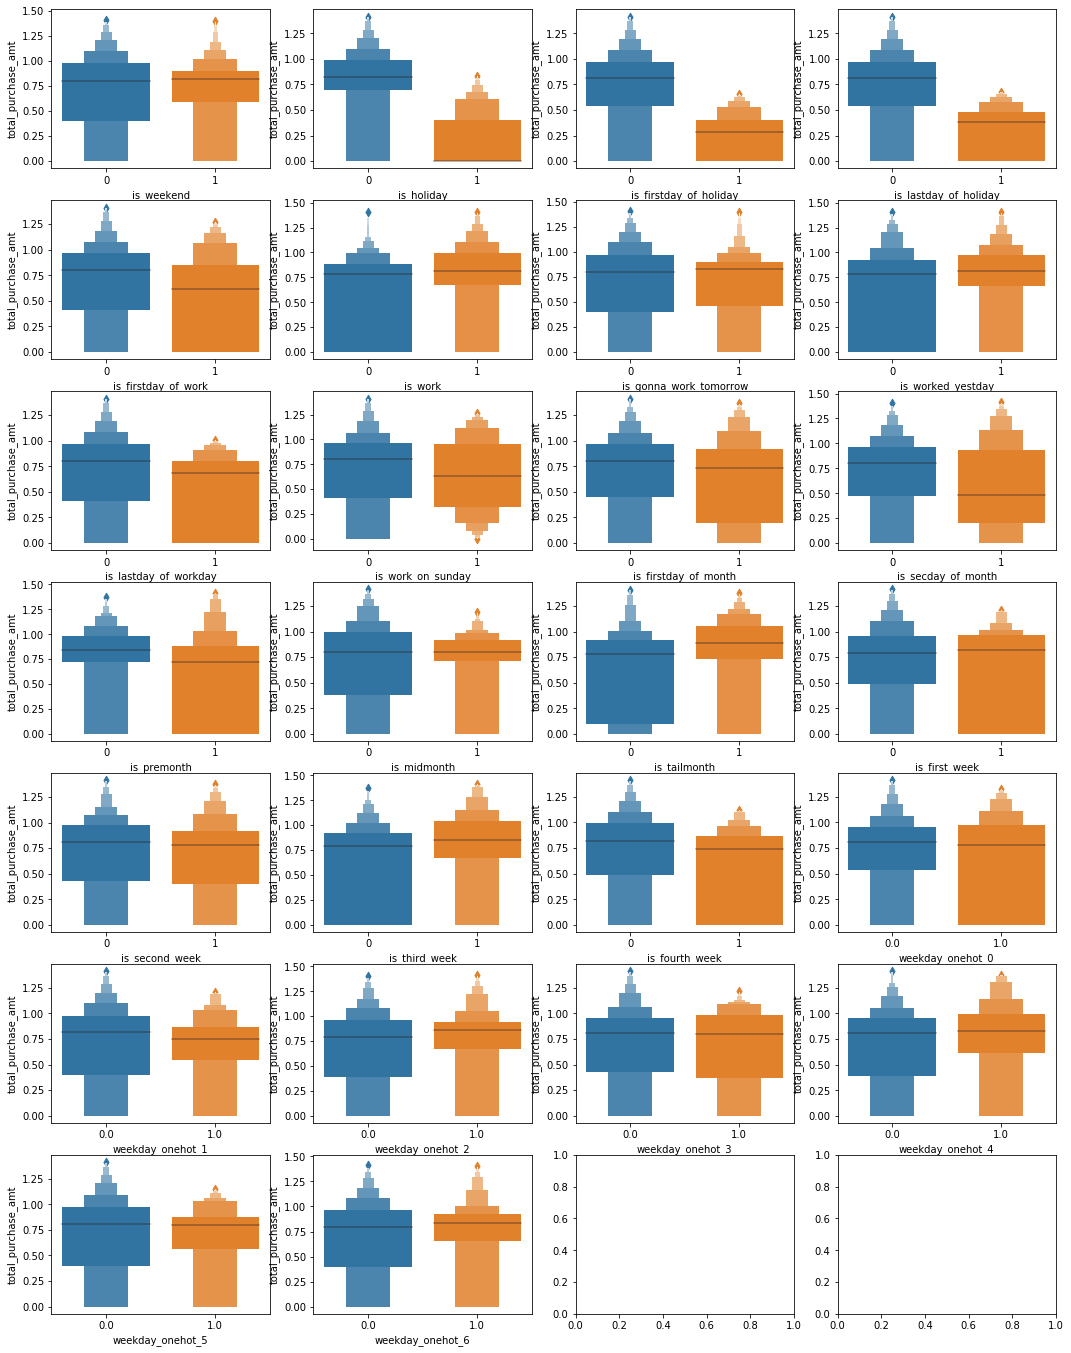

In [245]:
draw_boxplot(feature)

In [246]:
## Weed out features with low seperation ability
low_sep = ['is_work_on_sunday','is_first_week']


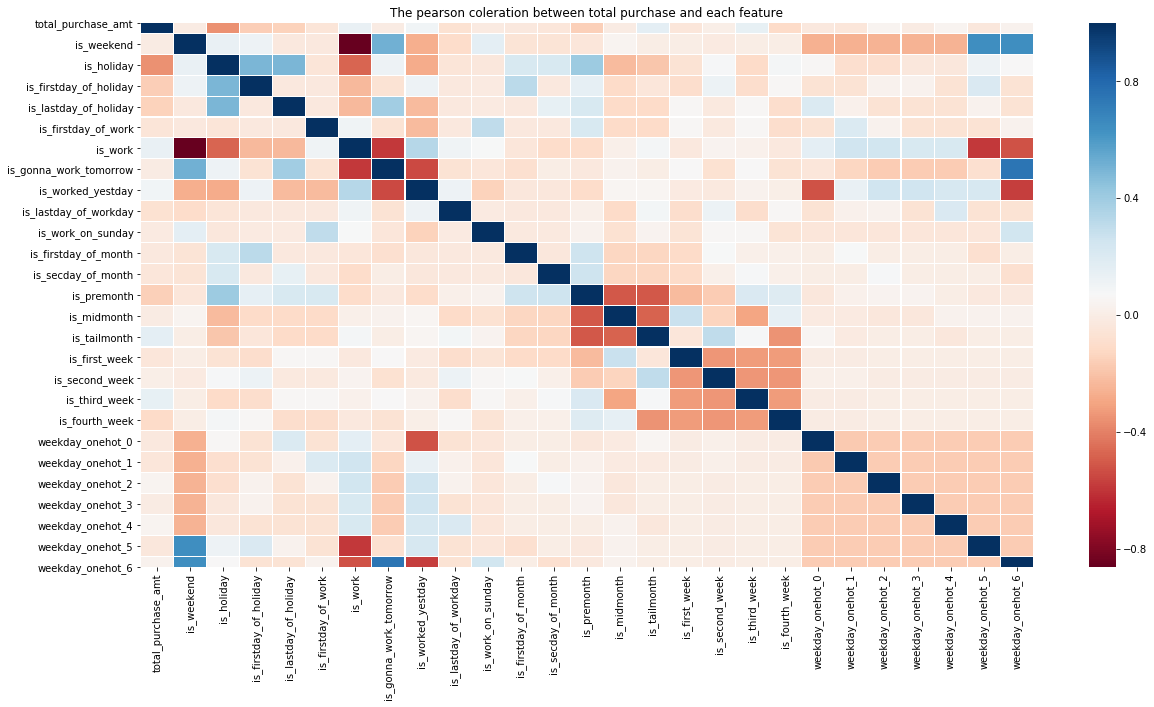

In [247]:
def draw_correlation_heatmap(data: pd.DataFrame, way:str = 'pearson')->None:
    feature = data.copy()
    plt.figure(figsize=(20,10))
    plt.title('The ' + way +' coleration between total purchase and each feature')
    sns.heatmap(feature[[x for x in feature.columns if x not in ['total_redeem_amt', 'date'] ]].corr(way),linecolor='white',
        linewidths=0.1,
        cmap="RdBu")
draw_correlation_heatmap(feature)

In [248]:
## Remove features with low correlation

temp = np.abs(feature[[x for x in feature.columns 
                       if x not in ['total_redeem_amt', 'date'] ]].corr('pearson')['total_purchase_amt'])
low_corr = list(set(temp[temp < 0.1].index))
low_corr

['is_firstday_of_work',
 'is_gonna_work_tomorrow',
 'weekday_onehot_0',
 'weekday_onehot_2',
 'weekday_onehot_1',
 'is_lastday_of_workday',
 'is_first_week',
 'weekday_onehot_6',
 'is_weekend',
 'is_firstday_of_month',
 'is_secday_of_month',
 'is_second_week',
 'weekday_onehot_5',
 'is_midmonth',
 'is_work_on_sunday',
 'weekday_onehot_4',
 'weekday_onehot_3']

### (3) Distance features

In [249]:
# Extract distance feature

def extract_distance_feature(data: pd.DataFrame)->pd.DataFrame:
    total_balance = data.copy()
    
    # How many days before the holiday
    total_balance['dis_to_nowork'] = 0
    for index, row in total_balance.iterrows():
        if row['is_work'] == 0:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_work'] == 1:
                    total_balance.loc[index - step, 'dis_to_nowork'] = step
                    step += 1
                else:
                    flag = 0

    total_balance['dis_from_nowork'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_work'] == 1:
            total_balance.loc[index, 'dis_from_nowork'] = step
        else:
            step = 0

    # How many days to go to work
    total_balance['dis_to_work'] = 0
    for index, row in total_balance.iterrows():
        if row['is_work'] == 1:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_work'] == 0:
                    total_balance.loc[index - step, 'dis_to_work'] = step
                    step += 1
                else:
                    flag = 0

    total_balance['dis_from_work'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_work'] == 0:
            total_balance.loc[index, 'dis_from_work'] = step
        else:
            step = 0


    # How many days before the holiday
    total_balance['dis_to_holiday'] = 0
    for index, row in total_balance.iterrows():
        if row['is_holiday'] == 1:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_holiday'] == 0:
                    total_balance.loc[index - step, 'dis_to_holiday'] = step
                    step += 1
                else:
                    flag = 0

    total_balance['dis_from_holiday'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_holiday'] == 0:
            total_balance.loc[index, 'dis_from_holiday'] = step
        else:
            step = 0

    # How many days are there before the last day of the holiday
    total_balance['dis_to_holiendday'] = 0
    for index, row in total_balance.iterrows():
        if row['is_lastday_of_holiday'] == 1:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_lastday_of_holiday'] == 0:
                    total_balance.loc[index - step, 'dis_to_holiendday'] = step
                    step += 1
                else:
                    flag = 0

    total_balance['dis_from_holiendday'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_lastday_of_holiday'] == 0:
            total_balance.loc[index, 'dis_from_holiendday'] = step
        else:
            step = 0

    # How many days from the beginning of the month
    total_balance['dis_from_startofmonth'] = np.abs(total_balance['day'])

    # How many days from the center of the month
    total_balance['dis_from_middleofmonth'] = np.abs(total_balance['day'] - 15)

    # How many days from the center of the week
    total_balance['dis_from_middleofweek'] = np.abs(total_balance['weekday'] - 3)

    # How many days from Sunday
    total_balance['dis_from_endofweek'] = np.abs(total_balance['weekday'] - 6)

    return total_balance

In [250]:
# merge distance feature to original dataset
total_balance = extract_distance_feature(total_balance)
feature = total_balance[[x for x in total_balance.columns if x not in date_indexs]]
feature

,date,total_purchase_amt,total_redeem_amt,is_weekend,is_holiday,is_firstday_of_holiday,is_lastday_of_holiday,is_firstday_of_work,is_work,is_gonna_work_tomorrow,...,dis_to_work,dis_from_work,dis_to_holiday,dis_from_holiday,dis_to_holiendday,dis_from_holiendday,dis_from_startofmonth,dis_from_middleofmonth,dis_from_middleofweek,dis_from_endofweek
0,2014-03-31,0.000000,0.000000,0,0,0,0,0,1,0,...,0,0,5,1,7,1,31,16,3,6
1,2014-04-01,0.730303,0.634370,0,0,0,0,0,1,0,...,0,0,4,2,6,2,1,14,2,5
2,2014-04-02,0.818276,0.761724,0,0,0,0,0,1,0,...,0,0,3,3,5,3,2,13,1,4
3,2014-04-03,0.768604,0.703255,0,0,0,0,0,1,0,...,0,0,2,4,4,4,3,12,0,3
4,2014-04-04,0.680148,0.926145,0,0,0,0,0,1,0,...,0,0,1,5,3,5,4,11,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2014-10-10,0.000000,0.000000,0,0,0,0,0,1,0,...,0,0,0,3,0,3,10,5,1,2
194,2014-10-11,0.000000,0.000000,1,0,0,0,0,0,0,...,2,1,0,4,0,4,11,4,2,1
195,2014-10-12,0.000000,0.000000,1,0,0,0,0,0,1,...,1,2,0,5,0,5,12,3,3,0
196,2014-10-13,0.000000,0.000000,0,0,0,0,0,1,0,...,0,0,0,6,0,6,13,2,3,6


### (4) Distance feature selection

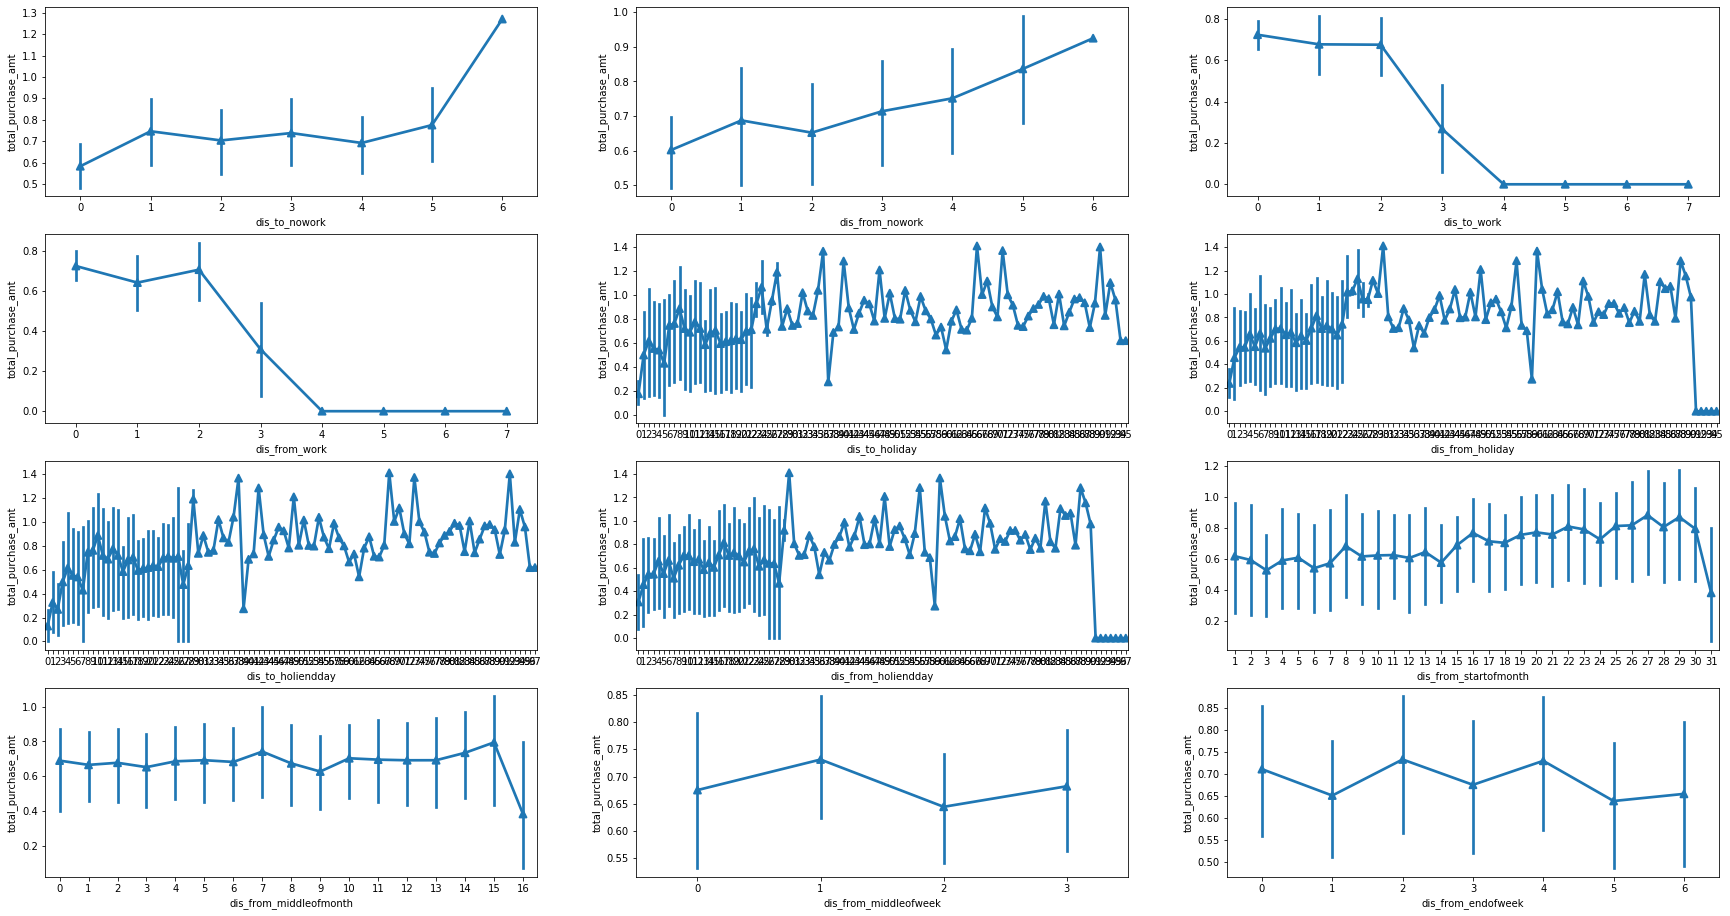

In [251]:
def draw_point_feature(data: pd.DataFrame)->None:
    feature = data.copy()
    f, axes = plt.subplots(data.shape[1] // 3, 3, figsize=(30, data.shape[1] // 3 * 4))
    count = 0
    for i in [x for x in feature.columns if (x not in date_indexs + labels + ['date'])]:
        sns.pointplot(x=i, y="total_purchase_amt",
                markers=["^", "o"], linestyles=["-", "--"],
                kind="point", data=feature, ax=axes[count // 3][count % 3] if data.shape[1] > 3 else axes[count])
        count += 1

dis_feature_indexs = [x for x in feature.columns if (x not in date_indexs + labels + ['date']) & ('dis' in x)]
draw_point_feature(feature[['total_purchase_amt'] + dis_feature_indexs])

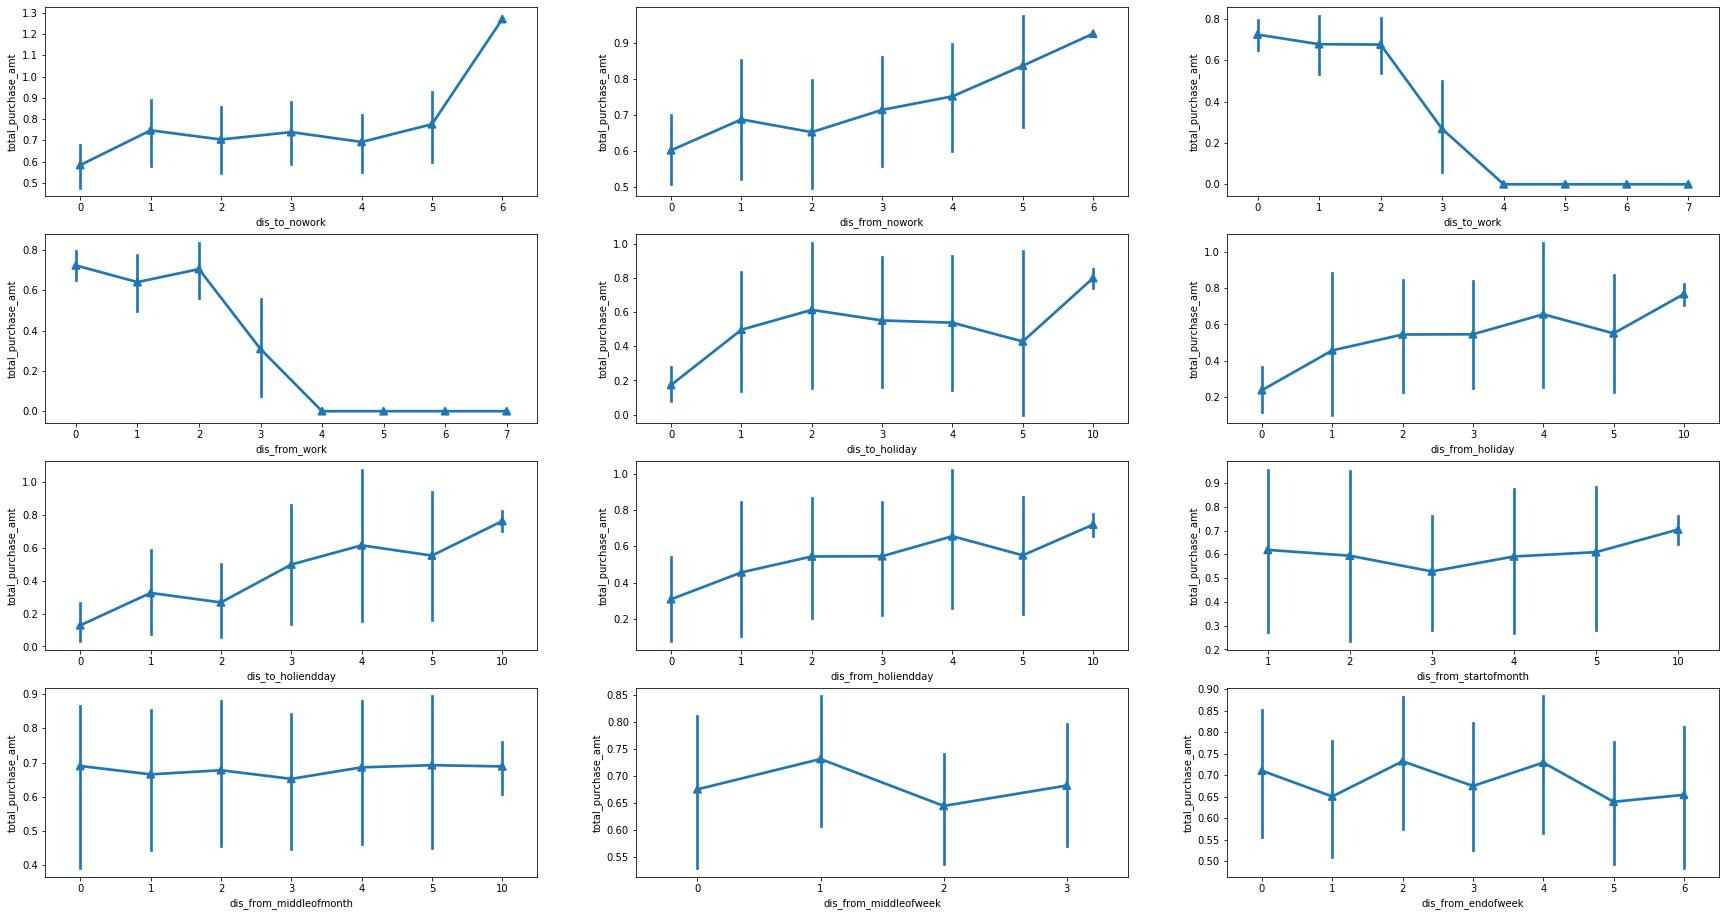

In [252]:
# Set threshold for the distance feature

def dis_change(x):
    if x > 5:
        x = 10
    return x


dis_holiday_feature = [x for x in total_balance.columns if 'dis' in x and 'holi' in x]
dis_month_feature = [x for x in total_balance.columns if 'dis' in x and 'month' in x]
total_balance[dis_holiday_feature] = total_balance[dis_holiday_feature].applymap(dis_change)
total_balance[dis_month_feature] = total_balance[dis_month_feature].applymap(dis_change)

feature = total_balance[[x for x in total_balance.columns if x not in date_indexs]]
draw_point_feature(feature[['total_purchase_amt'] + dis_feature_indexs])


In [253]:
## Weed out features with low seperation ability
low_sep += ['dis_to_holiday','dis_from_startofmonth','dis_from_middleofmonth']

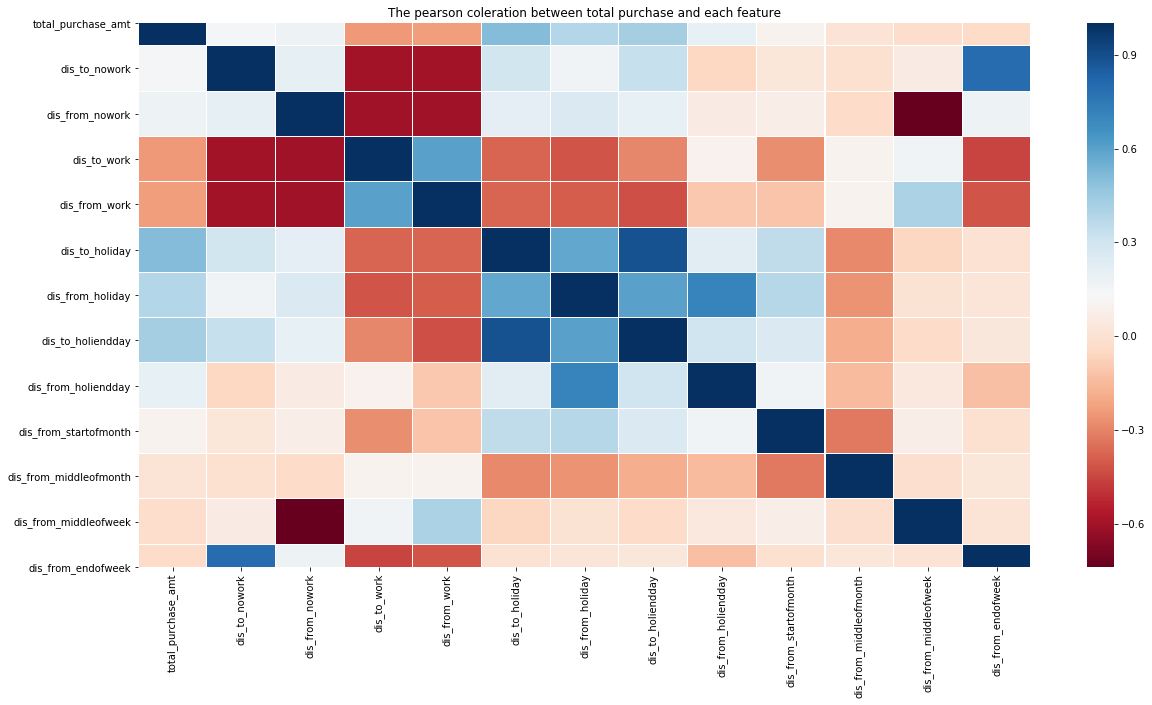

In [254]:
draw_correlation_heatmap(feature[['total_purchase_amt'] + dis_feature_indexs])

In [255]:
# Remove features with low correlation

temp = np.abs(feature[[x for x in feature.columns 
                       if ('dis' in x) | (x in ['total_purchase_amt']) ]].corr()['total_purchase_amt'])
low_corr += list(set(temp[temp < 0.1].index) )
low_corr

['is_firstday_of_work',
 'is_gonna_work_tomorrow',
 'weekday_onehot_0',
 'weekday_onehot_2',
 'weekday_onehot_1',
 'is_lastday_of_workday',
 'is_first_week',
 'weekday_onehot_6',
 'is_weekend',
 'is_firstday_of_month',
 'is_secday_of_month',
 'is_second_week',
 'weekday_onehot_5',
 'is_midmonth',
 'is_work_on_sunday',
 'weekday_onehot_4',
 'weekday_onehot_3',
 'dis_from_endofweek',
 'dis_from_middleofmonth',
 'dis_from_middleofweek']

### (5) Features over  peaks and roughs

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


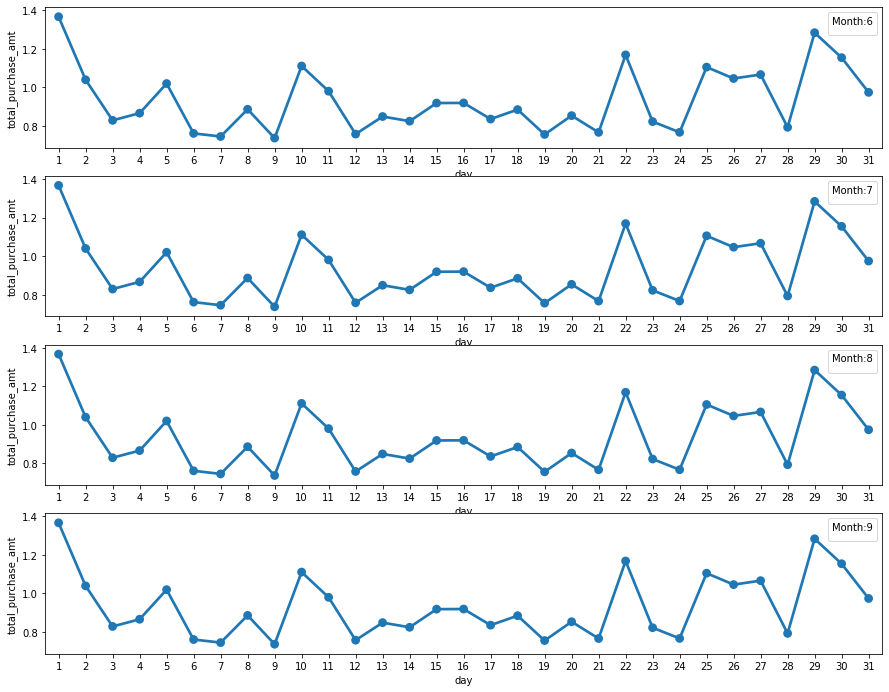

In [256]:
# observe peaks and roughs features

fig = plt.figure(figsize=(15,15))
for i in range(6, 10):
    plt.subplot(5,1,i - 5)
    total_balance_2 = total_balance[(total_balance['date'] >= datetime.date(2014,8,1)) & (total_balance['date'] < datetime.date(2014,9,1))]
    sns.pointplot(x=total_balance_2['day'],y=total_balance_2['total_purchase_amt'])
    plt.legend().set_title('Month:' + str(i))
    

In [257]:

def extract_peak_feature(data: pd.DataFrame)->pd.DataFrame:
    total_balance = data.copy()
    total_balance['dis_from_purchase_peak'] = np.abs(total_balance['weekday'] - 1)
    total_balance['dis_from_purchase_valley'] = np.abs(total_balance['weekday'] - 6)
    
    return total_balance

total_balance = extract_peak_feature(total_balance)
feature = total_balance[[x for x in total_balance.columns if x not in date_indexs]]
feature

,date,total_purchase_amt,total_redeem_amt,is_weekend,is_holiday,is_firstday_of_holiday,is_lastday_of_holiday,is_firstday_of_work,is_work,is_gonna_work_tomorrow,...,dis_to_holiday,dis_from_holiday,dis_to_holiendday,dis_from_holiendday,dis_from_startofmonth,dis_from_middleofmonth,dis_from_middleofweek,dis_from_endofweek,dis_from_purchase_peak,dis_from_purchase_valley
0,2014-03-31,0.000000,0.000000,0,0,0,0,0,1,0,...,5,1,10,1,10,10,3,6,1,6
1,2014-04-01,0.730303,0.634370,0,0,0,0,0,1,0,...,4,2,10,2,1,10,2,5,0,5
2,2014-04-02,0.818276,0.761724,0,0,0,0,0,1,0,...,3,3,5,3,2,10,1,4,1,4
3,2014-04-03,0.768604,0.703255,0,0,0,0,0,1,0,...,2,4,4,4,3,10,0,3,2,3
4,2014-04-04,0.680148,0.926145,0,0,0,0,0,1,0,...,1,5,3,5,4,10,1,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2014-10-10,0.000000,0.000000,0,0,0,0,0,1,0,...,0,3,0,3,10,5,1,2,3,2
194,2014-10-11,0.000000,0.000000,1,0,0,0,0,0,0,...,0,4,0,4,10,4,2,1,4,1
195,2014-10-12,0.000000,0.000000,1,0,0,0,0,0,1,...,0,5,0,5,10,3,3,0,5,0
196,2014-10-13,0.000000,0.000000,0,0,0,0,0,1,0,...,0,10,0,10,10,2,3,6,1,6


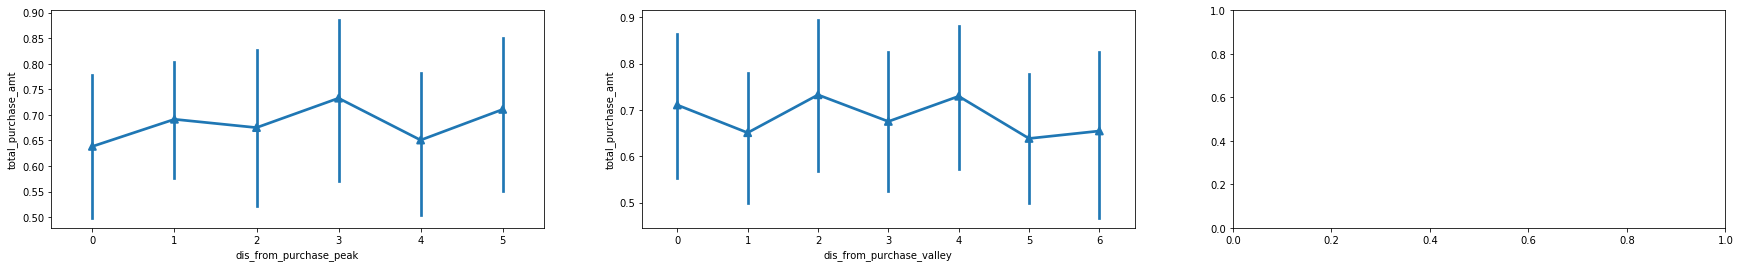

In [258]:
draw_point_feature(feature[['total_purchase_amt'] + ['dis_from_purchase_peak','dis_from_purchase_valley']])
temp = np.abs(feature[[x for x in feature.columns if ('peak' in x) or ('valley' in x) or (x in ['total_purchase_amt']) ]].corr()['total_purchase_amt'])

### (6) Periodic feature

In [259]:
def generate_rate(df, month_index):
    total_balance = df.copy()
    pure_balance = total_balance[['date','total_purchase_amt','total_redeem_amt']]
    pure_balance = pure_balance[(pure_balance['date'] >= datetime.date(2014,3,1)) & (pure_balance['date'] < datetime.date(2014, month_index, 1))]
    pure_balance['weekday'] = pure_balance['date'].dt.weekday
    pure_balance['day'] = pure_balance['date'].dt.day
    pure_balance['week'] = pure_balance['date'].dt.week
    pure_balance['month'] = pure_balance['date'].dt.month
    weekday_rate = pure_balance[['weekday']+labels].groupby('weekday',as_index=False).mean()
    for name in labels:
        weekday_rate = weekday_rate.rename(columns={name: name+'_weekdaymean'})
    weekday_rate['total_purchase_amt_weekdaymean'] /= np.mean(pure_balance['total_purchase_amt'])
    weekday_rate['total_redeem_amt_weekdaymean'] /= np.mean(pure_balance['total_redeem_amt'])
    pure_balance = pd.merge(pure_balance, weekday_rate, on='weekday', how='left')
    weekday_count = pure_balance[['day','weekday','date']].groupby(['day','weekday'],as_index=False).count()
    weekday_count = pd.merge(weekday_count, weekday_rate, on = 'weekday')
    weekday_count['total_purchase_amt_weekdaymean'] *= weekday_count['date'] / (len(set(pure_balance['month'])) - 1)
    weekday_count['total_redeem_amt_weekdaymean'] *= weekday_count['date'] / (len(set(pure_balance['month'])) - 1)
    day_rate = weekday_count.drop(['weekday','date'],axis=1).groupby('day',as_index=False).sum()
    weekday_rate.columns = ['weekday','purchase_weekdayrate','redeem_weekdayrate']
    day_rate.columns = ['day','purchase_dayrate','redeem_dayrate']
    day_rate['date'] = datetime.datetime(2014, month_index, 1)
    for index, row in day_rate.iterrows():
        if month_index in (2,4,6,9) and row['day'] == 31:
            continue
        day_rate.loc[index, 'date'] = datetime.datetime(2014, month_index, int(row['day']))
    day_rate['weekday'] = day_rate['date'].dt.weekday
    day_rate = pd.merge(day_rate, weekday_rate, on='weekday')
    day_rate['purchase_dayrate'] = day_rate['purchase_weekdayrate'] / day_rate['purchase_dayrate']
    day_rate['redeem_dayrate'] = day_rate['redeem_weekdayrate'] / day_rate['redeem_dayrate']
    weekday_rate['month'] = month_index
    day_rate['month'] = month_index
    
    return weekday_rate, day_rate[['day','purchase_dayrate','redeem_dayrate','month']].sort_values('day')

In [260]:
# Generate periodic feature and merge into dataset

weekday_rate_list = []
day_rate_list = []
for i in range(3, 10):
    weekday_rate, day_rate = generate_rate(total_balance, i)
    weekday_rate_list.append(weekday_rate.reset_index(drop=True))
    day_rate_list.append(day_rate.reset_index(drop=True))

weekday_rate_list = pd.concat(weekday_rate_list).reset_index(drop=True)
day_rate_list = pd.concat(day_rate_list).reset_index(drop=True)
total_balance = pd.merge(total_balance, weekday_rate_list, on=['weekday','month'], how='left')
total_balance = pd.merge(total_balance, day_rate_list, on=['day','month'], how='left')


for i in [x for x in total_balance.columns 
          if 'rate' in x and x not in labels + date_indexs]:
    total_balance[i] = total_balance[i].fillna(np.nanmedian(total_balance[i]))

feature = total_balance[[x for x in total_balance.columns if x not in date_indexs]]
feature


,date,total_purchase_amt,total_redeem_amt,is_weekend,is_holiday,is_firstday_of_holiday,is_lastday_of_holiday,is_firstday_of_work,is_work,is_gonna_work_tomorrow,...,dis_from_startofmonth,dis_from_middleofmonth,dis_from_middleofweek,dis_from_endofweek,dis_from_purchase_peak,dis_from_purchase_valley,purchase_weekdayrate,redeem_weekdayrate,purchase_dayrate,redeem_dayrate
0,2014-03-31,0.000000,0.000000,0,0,0,0,0,1,0,...,10,10,3,6,1,6,1.010953,1.01058,0.98721,1.00124
1,2014-04-01,0.730303,0.634370,0,0,0,0,0,1,0,...,1,10,2,5,0,5,1.010953,1.01058,0.98721,1.00124
2,2014-04-02,0.818276,0.761724,0,0,0,0,0,1,0,...,2,10,1,4,1,4,1.010953,1.01058,0.98721,1.00124
3,2014-04-03,0.768604,0.703255,0,0,0,0,0,1,0,...,3,10,0,3,2,3,1.010953,1.01058,0.98721,1.00124
4,2014-04-04,0.680148,0.926145,0,0,0,0,0,1,0,...,4,10,1,2,3,2,1.010953,1.01058,0.98721,1.00124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2014-10-10,0.000000,0.000000,0,0,0,0,0,1,0,...,10,5,1,2,3,2,1.010953,1.01058,0.98721,1.00124
194,2014-10-11,0.000000,0.000000,1,0,0,0,0,0,0,...,10,4,2,1,4,1,1.010953,1.01058,0.98721,1.00124
195,2014-10-12,0.000000,0.000000,1,0,0,0,0,0,1,...,10,3,3,0,5,0,1.010953,1.01058,0.98721,1.00124
196,2014-10-13,0.000000,0.000000,0,0,0,0,0,1,0,...,10,2,3,6,1,6,1.010953,1.01058,0.98721,1.00124


### (7) Screen periodic feature

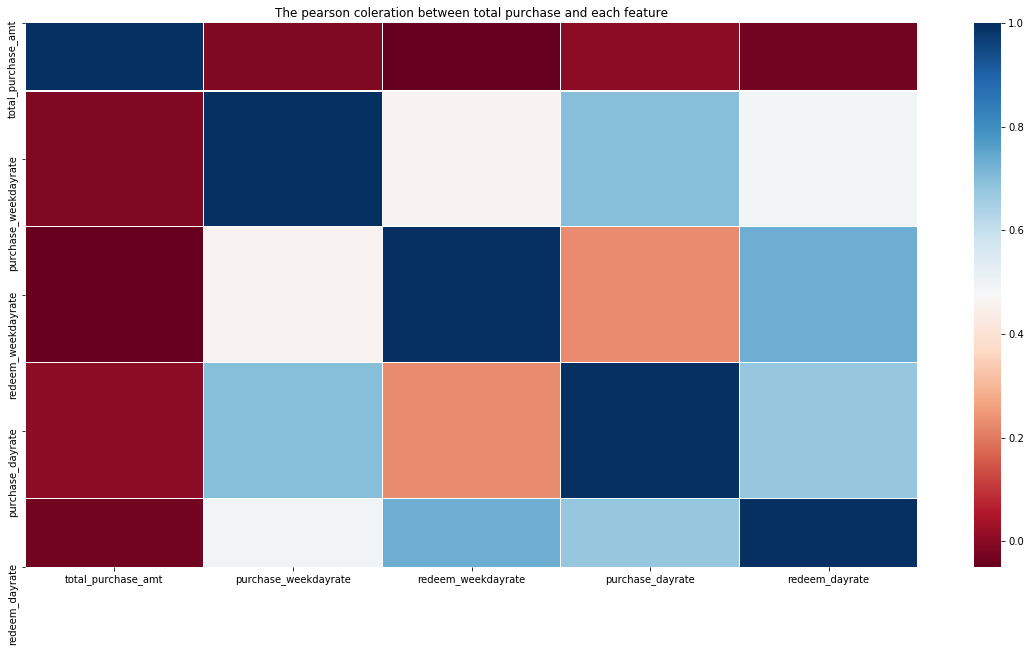

In [261]:
draw_correlation_heatmap(total_balance[['total_purchase_amt'] 
                                       + [x for x in total_balance.columns 
                                          if 'rate' in x and x not in labels + date_indexs]])

In [262]:
# Remove features with low correlation
temp = np.abs(total_balance[['total_purchase_amt'] 
                                       + [x for x in total_balance.columns 
                                          if 'rate' in x and x not in labels + date_indexs]].corr()['total_purchase_amt'])
low_corr += list(set(temp[temp < 0.1].index))
low_corr

['is_firstday_of_work',
 'is_gonna_work_tomorrow',
 'weekday_onehot_0',
 'weekday_onehot_2',
 'weekday_onehot_1',
 'is_lastday_of_workday',
 'is_first_week',
 'weekday_onehot_6',
 'is_weekend',
 'is_firstday_of_month',
 'is_secday_of_month',
 'is_second_week',
 'weekday_onehot_5',
 'is_midmonth',
 'is_work_on_sunday',
 'weekday_onehot_4',
 'weekday_onehot_3',
 'dis_from_endofweek',
 'dis_from_middleofmonth',
 'dis_from_middleofweek',
 'redeem_weekdayrate',
 'purchase_dayrate',
 'purchase_weekdayrate',
 'redeem_dayrate']

### (8) Extract rolling features

In [263]:
## Extract rolling features
def get_amtfeature_with_time(data: pd.DataFrame)->pd.DataFrame:
    df_tmp_ = data[labels + date_indexs + ['date']].copy()
    total_balance = data.copy()
    
    df_tmp_ = df_tmp_[(df_tmp_['date']>=datetime.date(2014,3,3))]
    df_tmp_['weekday'] = df_tmp_['date'].dt.weekday + 1
    df_tmp_['week'] = df_tmp_['date'].dt.week - min(df_tmp_['date'].dt.week) + 1
    df_tmp_['day'] = df_tmp_['date'].dt.day
    df_tmp_['month'] = df_tmp_['date'].dt.month
    df_tmp_.reset_index(inplace=True)
    del df_tmp_['index']
    df_purchase = pd.DataFrame(columns = ['weekday1','weekday2','weekday3','weekday4',
                                          'weekday5','weekday6','weekday7'])
    count = 0

    for i in range(len(df_tmp_)):
        df_purchase.loc[count,'weekday'+str(df_tmp_.loc[i,'weekday'])] = df_tmp_.loc[i,'total_purchase_amt']
        if df_tmp_.loc[i,'weekday'] == 7:
            count = count + 1

    df_tmp_['purchase_weekday_median'] = np.nan
    df_tmp_['purchase_weekday_mean'] = np.nan
    df_tmp_['purchase_weekday_min'] = np.nan
    df_tmp_['purchase_weekday_max'] = np.nan
    df_tmp_['purchase_weekday_std'] = np.nan
    df_tmp_['purchase_weekday_skew'] = np.nan

    
    for i in range(len(df_tmp_)):
        if i > 4*7-1:
            df_tmp_.loc[i,'purchase_weekday_median'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].median()

            df_tmp_.loc[i,'purchase_weekday_mean'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].mean()

            df_tmp_.loc[i,'purchase_weekday_min'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].min()    

            df_tmp_.loc[i,'purchase_weekday_max'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].max()   

            df_tmp_.loc[i,'purchase_weekday_std'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].std() 

            df_tmp_.loc[i,'purchase_weekday_skew'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].skew() 

    colList = ['purchase_weekday_median','purchase_weekday_mean','purchase_weekday_min',
               'purchase_weekday_max','purchase_weekday_std','purchase_weekday_skew']
    total_balance = pd.merge(total_balance, df_tmp_[colList+['day','month']], on=['day','month'], how='left')
    return total_balance

In [264]:
total_balance = get_amtfeature_with_time(total_balance)
for i in [x for x in total_balance.columns 
          if '_weekday_' in x and x not in labels + date_indexs]:
    total_balance[i] = total_balance[i].fillna(np.nanmedian(total_balance[i]))
    
feature = total_balance[[x for x in total_balance.columns if x not in date_indexs]]
feature

,date,total_purchase_amt,total_redeem_amt,is_weekend,is_holiday,is_firstday_of_holiday,is_lastday_of_holiday,is_firstday_of_work,is_work,is_gonna_work_tomorrow,...,purchase_weekdayrate,redeem_weekdayrate,purchase_dayrate,redeem_dayrate,purchase_weekday_median,purchase_weekday_mean,purchase_weekday_min,purchase_weekday_max,purchase_weekday_std,purchase_weekday_skew
0,2014-03-31,0.000000,0.000000,0,0,0,0,0,1,0,...,1.010953,1.01058,0.98721,1.00124,0.861540,0.846216,0.381202,1.214190,0.228186,-0.797589
1,2014-04-01,0.730303,0.634370,0,0,0,0,0,1,0,...,1.010953,1.01058,0.98721,1.00124,0.861540,0.846216,0.381202,1.214190,0.228186,-0.797589
2,2014-04-02,0.818276,0.761724,0,0,0,0,0,1,0,...,1.010953,1.01058,0.98721,1.00124,0.861540,0.846216,0.381202,1.214190,0.228186,-0.797589
3,2014-04-03,0.768604,0.703255,0,0,0,0,0,1,0,...,1.010953,1.01058,0.98721,1.00124,0.861540,0.846216,0.381202,1.214190,0.228186,-0.797589
4,2014-04-04,0.680148,0.926145,0,0,0,0,0,1,0,...,1.010953,1.01058,0.98721,1.00124,0.861540,0.846216,0.381202,1.214190,0.228186,-0.797589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2014-10-10,0.000000,0.000000,0,0,0,0,0,1,0,...,1.010953,1.01058,0.98721,1.00124,0.847894,0.759837,0.000000,1.372205,0.424407,-0.787648
194,2014-10-11,0.000000,0.000000,1,0,0,0,0,0,0,...,1.010953,1.01058,0.98721,1.00124,0.807907,0.674896,0.000000,1.154141,0.367643,-1.020112
195,2014-10-12,0.000000,0.000000,1,0,0,0,0,0,1,...,1.010953,1.01058,0.98721,1.00124,0.836083,0.737051,0.000000,1.402358,0.399798,-0.946312
196,2014-10-13,0.000000,0.000000,0,0,0,0,0,1,0,...,1.010953,1.01058,0.98721,1.00124,0.781029,0.677933,0.000000,1.328019,0.449344,-0.534154


### (9) Screen rolling features

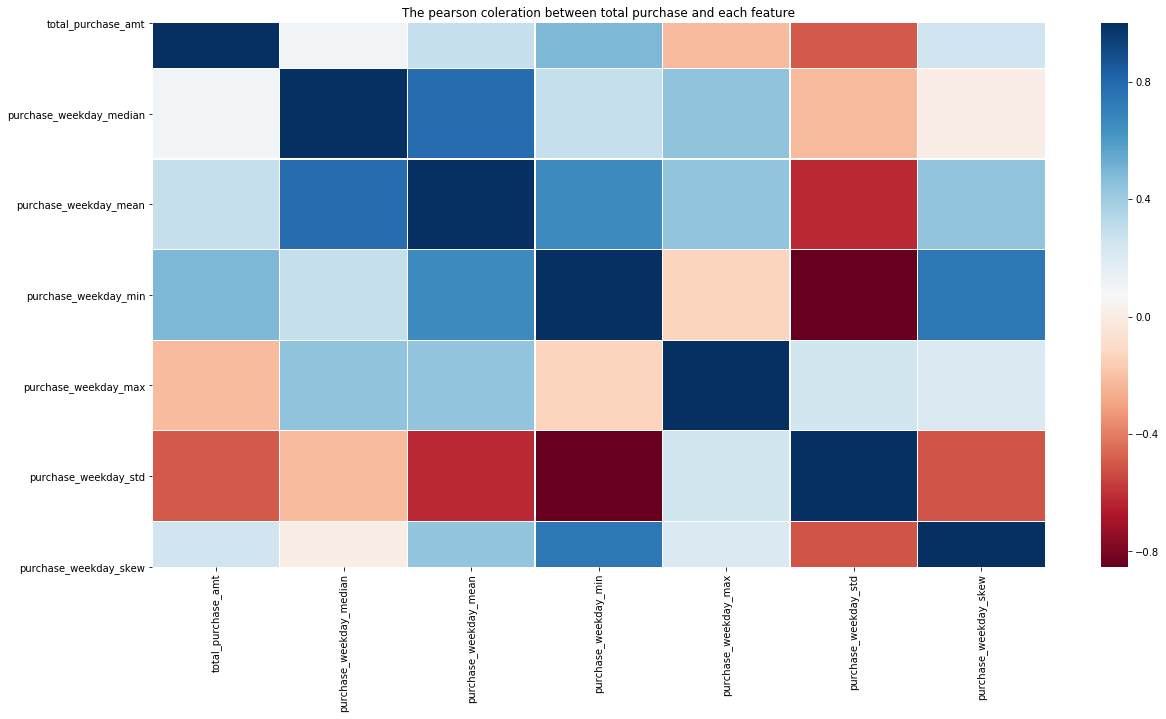

In [265]:
draw_correlation_heatmap(total_balance[['total_purchase_amt'] + 
                                      ['purchase_weekday_median',
                                      'purchase_weekday_mean','purchase_weekday_min',
                                       'purchase_weekday_max','purchase_weekday_std',
                                       'purchase_weekday_skew'
                                      ]])

In [266]:
temp = np.abs(total_balance[['total_purchase_amt'] + 
                                      ['purchase_weekday_median',
                                      'purchase_weekday_mean','purchase_weekday_min',
                                       'purchase_weekday_max','purchase_weekday_std',
                                       'purchase_weekday_skew'
                                      ]].corr()['total_purchase_amt'])
low_corr += list(set(temp[temp < 0.1].index))
low_corr


['is_firstday_of_work',
 'is_gonna_work_tomorrow',
 'weekday_onehot_0',
 'weekday_onehot_2',
 'weekday_onehot_1',
 'is_lastday_of_workday',
 'is_first_week',
 'weekday_onehot_6',
 'is_weekend',
 'is_firstday_of_month',
 'is_secday_of_month',
 'is_second_week',
 'weekday_onehot_5',
 'is_midmonth',
 'is_work_on_sunday',
 'weekday_onehot_4',
 'weekday_onehot_3',
 'dis_from_endofweek',
 'dis_from_middleofmonth',
 'dis_from_middleofweek',
 'redeem_weekdayrate',
 'purchase_dayrate',
 'purchase_weekdayrate',
 'redeem_dayrate']

## 1.2 Feature extracting

### (1)  Eliminating features that cannot be effectively segmented

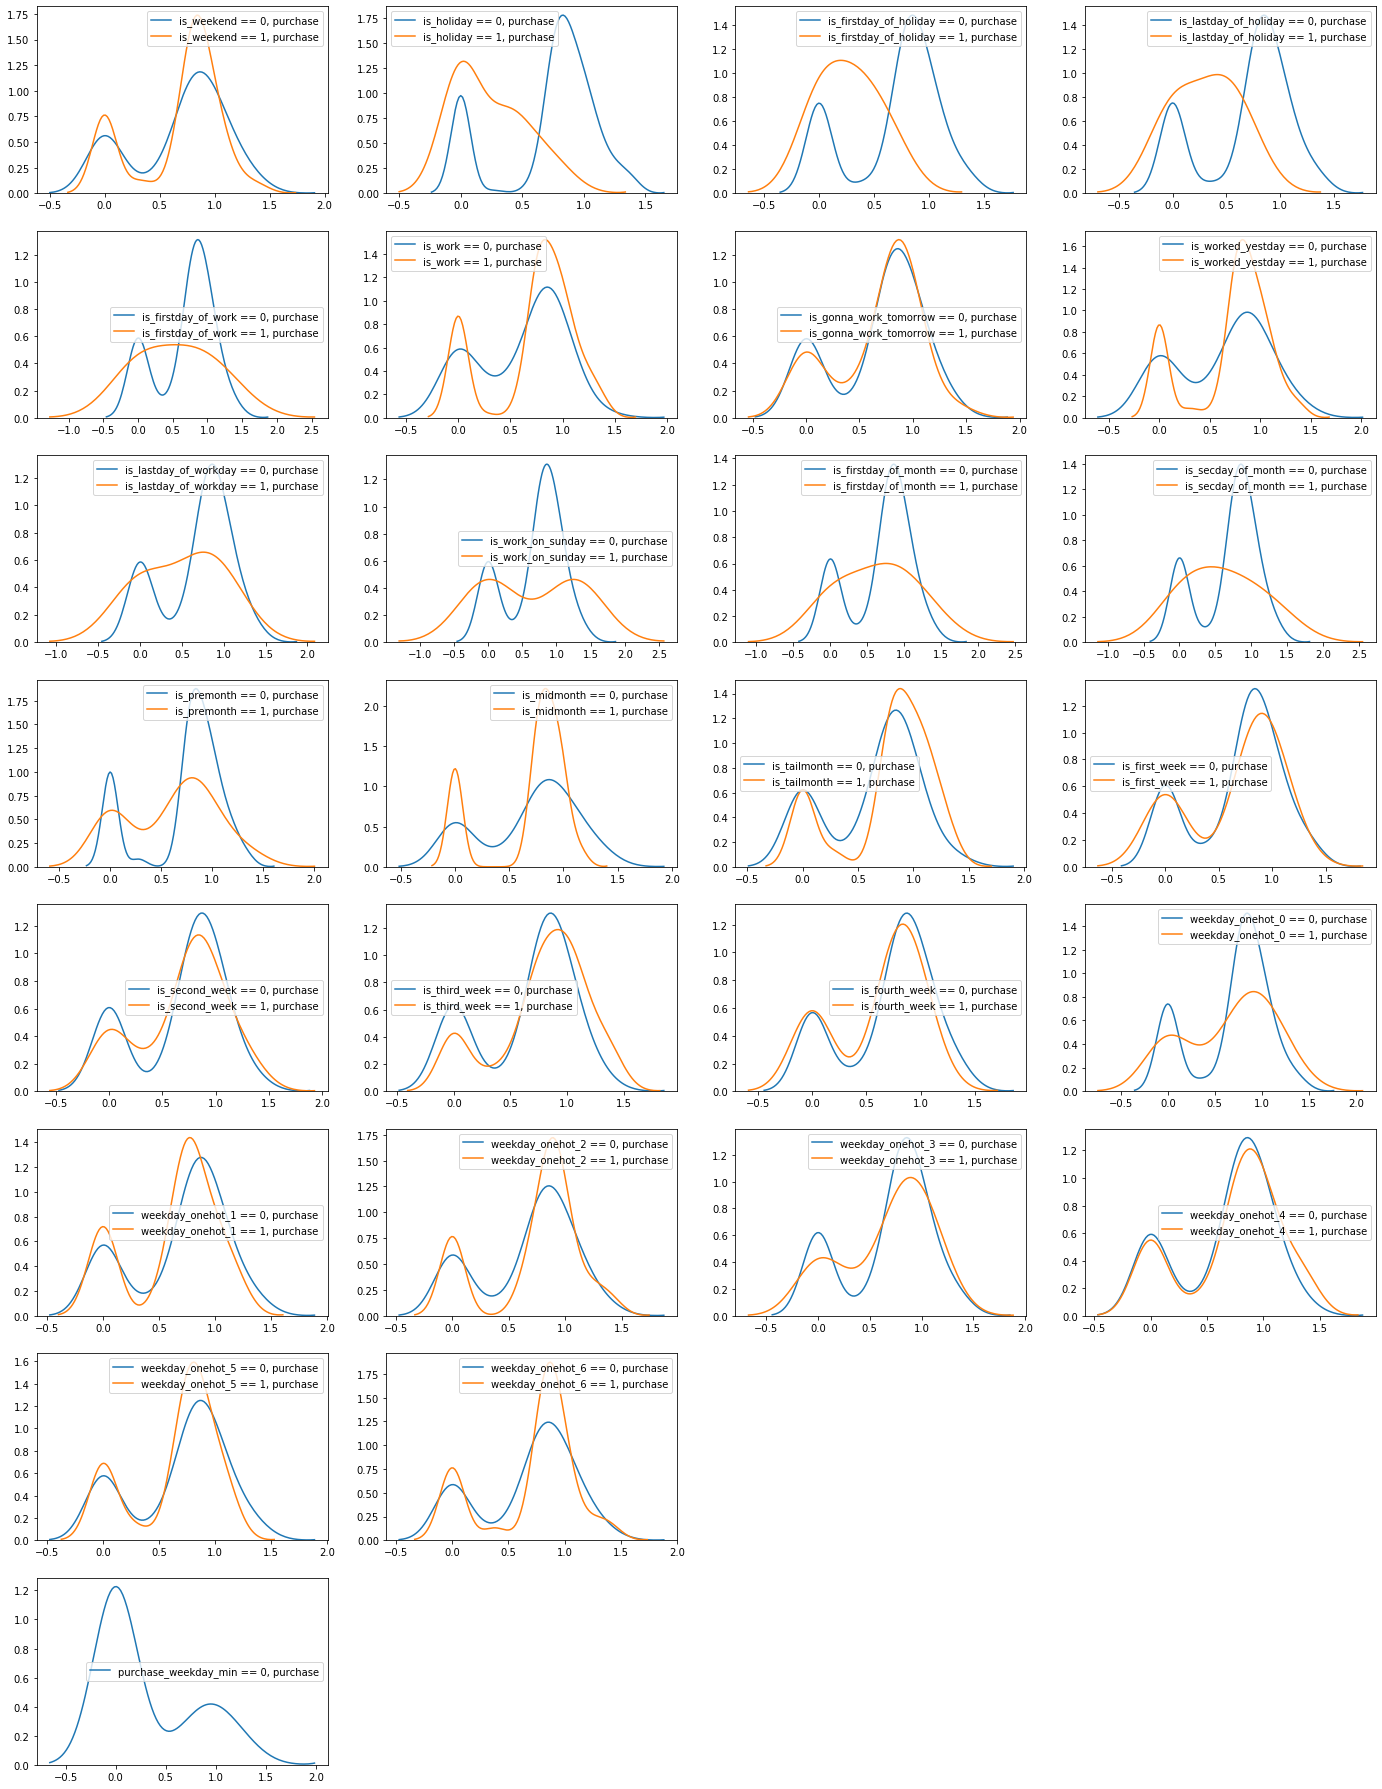

In [267]:
# Draw the distribution estimation graph of each feature segmentation data set
plt.figure(figsize=(4 * 6, 6 * len(feature.columns) / 6))
count = 0
for i in [x for x in feature.columns 
          if (x not in labels + date_indexs + ['date']) 
          & ('amt' not in x) & ('dis' not in x) & ('rate' not in x)]:
    count += 1
    if feature[feature[i] == 0].empty:
        continue
    plt.subplot(len(feature.columns) / 4, 4, count)
    
    ax = sns.kdeplot(feature[feature[i] == 0]['total_purchase_amt'], label= str(i) + ' == 0, purchase')
    ax = sns.kdeplot(feature[feature[i] == 1]['total_purchase_amt'], label= str(i) + ' == 1, purchase') 

In [268]:
# Delete the features that are not obvious for data set division
low_sep += ['is_gonna_work_tomorrow','is_fourth_week','weekday_onehot_4']

### (2) Delete multicollinearity feature

In [269]:
outside = pd.read_csv("data/feature-all2.csv", index_col=0)
total_balance.dropna(inplace=True)
total_balance.drop_duplicates(inplace=True)
total_balance = pd.concat((total_balance,outside["SHIBOR"]),axis=1)

In [270]:
feature = total_balance[[i for i in total_balance.columns 
                            if i not in low_sep+date_indexs]]

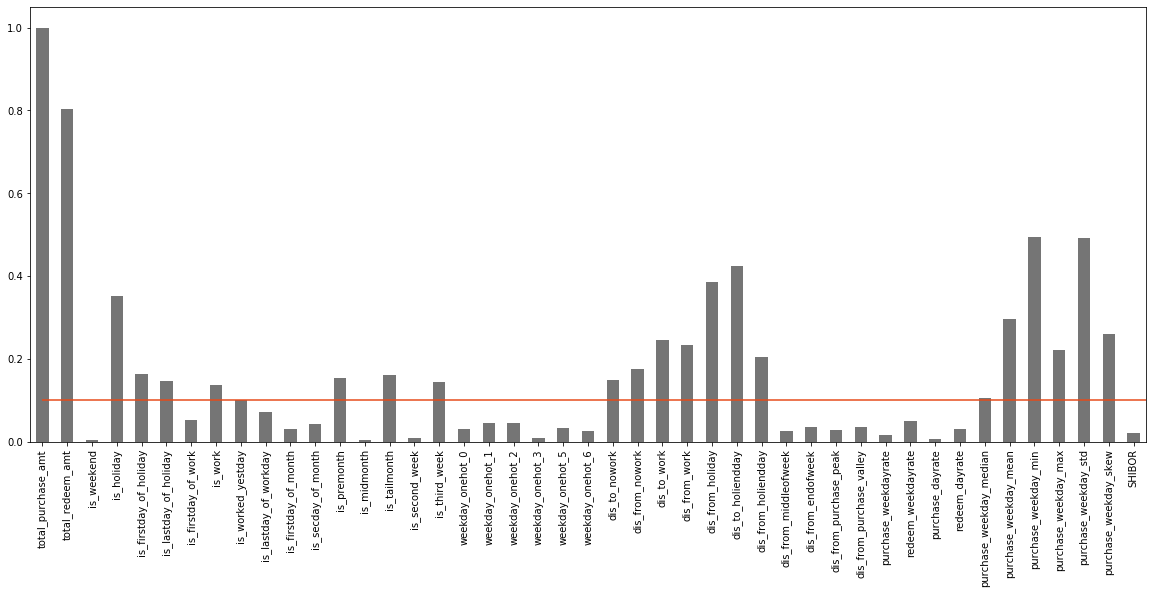

In [271]:
atemp = feature.corr()["total_purchase_amt"]
plt.figure(figsize=(20,8))
atemp.abs().plot(kind="bar",color = "#757575")
plt.hlines(0.1,0,60,color="#E64A19")

In [272]:
feature = total_balance[[i for i in total_balance.columns 
                            if i not in low_corr+low_sep+date_indexs]]

In [273]:
purchase_cors = feature.corr()
purchase_cors['total_redeem_amt'] = np.abs(purchase_cors['total_redeem_amt'])
feature_lists = list(purchase_cors.sort_values(by='total_redeem_amt',ascending=False).index)[2:]
feature_temp = feature.dropna()

In [274]:
thershold = 0.8
for i in range(len(feature_lists)):
    for k in range(len(feature_lists)-1, -1, -1):
        if i >= len(feature_lists) or k >= len(feature_lists) or i == k:
            break
        if np.abs(np.corrcoef(feature_temp[feature_lists[i]], feature_temp[feature_lists[k]])[0][1]) > thershold:
            higher_feature_temp = feature_temp[feature_lists[i]] * feature_temp[feature_lists[k]]
            if np.abs(np.corrcoef(feature_temp[feature_lists[i]], higher_feature_temp)[0][1]) <= thershold:
                name = str(feature_lists[i]) + '%%%%' + str(feature_lists[k])
                feature_temp[name] = higher_feature_temp
                feature[name] = feature[feature_lists[i]] * feature[feature_lists[k]]
                feature_lists.append(name)
            feature_temp = feature_temp.drop(feature_lists[k], axis=1)
            feature_lists.remove(feature_lists[k])
            
feature.drop([x for x in feature.columns if "%%%%" in x], axis=1, inplace= True)

### (3) Select winning features

In [275]:
feature.columns

Index(['date', 'total_purchase_amt', 'total_redeem_amt', 'is_holiday',
       'is_firstday_of_holiday', 'is_lastday_of_holiday', 'is_work',
       'is_worked_yestday', 'is_premonth', 'is_tailmonth', 'is_third_week',
       'dis_to_nowork', 'dis_from_nowork', 'dis_to_work', 'dis_from_work',
       'dis_from_holiday', 'dis_to_holiendday', 'dis_from_holiendday',
       'dis_from_purchase_peak', 'dis_from_purchase_valley',
       'purchase_weekday_median', 'purchase_weekday_mean',
       'purchase_weekday_min', 'purchase_weekday_max', 'purchase_weekday_std',
       'purchase_weekday_skew', 'SHIBOR'],
      dtype='object')

In [276]:

def split_data_underline(data):
    trainset = data[(datetime.date(2014,4,1) <= data['date']) & (data['date'] < datetime.date(2014,8,1))]
    testset = data[(datetime.date(2014,8,1) <= data['date']) & (data['date'] < datetime.date(2014,9,1))]
    return trainset, testset

### (4) Select the features with high Shapley value

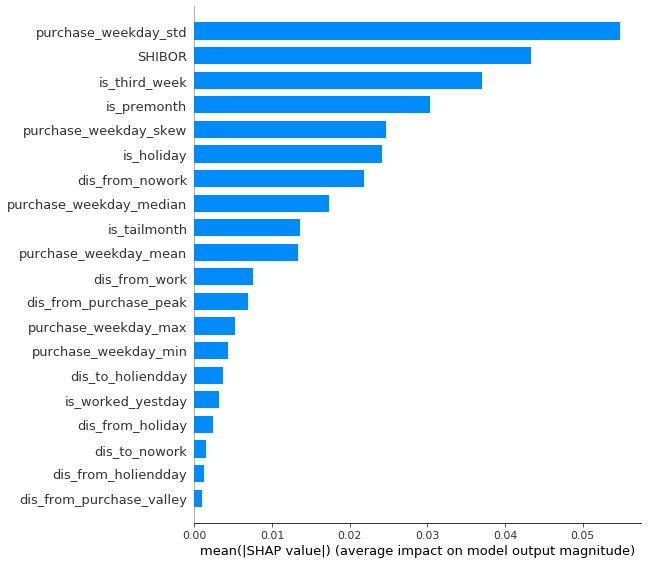

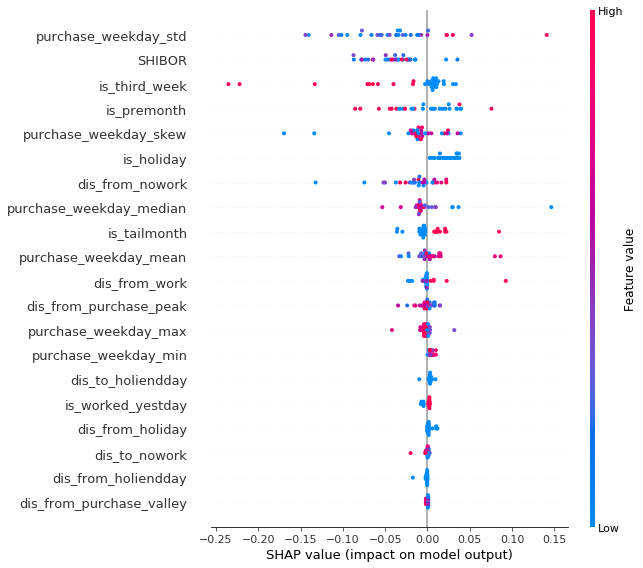

In [277]:
shap.initjs()
from sklearn import tree
model = tree.DecisionTreeRegressor()
train, test = split_data_underline(feature.dropna())
features = [x for x in train.columns if x not in date_indexs]
model.fit(train[features].drop(labels+['date'], axis=1), train['total_purchase_amt'])

explainer = shap.TreeExplainer(model)
shap_testues = explainer.shap_values(test[features].drop(labels+['date'], axis=1))

shap.summary_plot(shap_testues, test[features].drop(labels+['date'], axis=1), plot_type='bar')

shap.summary_plot(shap_testues, test[features].drop(labels+['date'], axis=1))

tree_important_purchase = pd.DataFrame(np.mean(np.abs(shap_testues), axis=0),[x for x in features if x not in labels + date_indexs + ['date']]).reset_index()

In [278]:
tree_important_purchase = tree_important_purchase.sort_values(0, ascending=False).reset_index(drop=True)
tree_important_purchase = list(tree_important_purchase[:15]['index'])

In [279]:
tree_important_purchase

['purchase_weekday_std',
 'SHIBOR',
 'is_third_week',
 'is_premonth',
 'purchase_weekday_skew',
 'is_holiday',
 'dis_from_nowork',
 'purchase_weekday_median',
 'is_tailmonth',
 'purchase_weekday_mean',
 'dis_from_work',
 'dis_from_purchase_peak',
 'purchase_weekday_max',
 'purchase_weekday_min',
 'dis_to_holiendday']

In [280]:

def draw_cloud(feature_index: List[str])->None:
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    ciyun = WordCloud(background_color='white', max_font_size=40)
    ciyun.generate(text=''.join([x+' ' for x in feature_index if x != 'total_purchase_amt']))
    plt.imshow(ciyun, interpolation='bilinear')
    plt.axis("off")


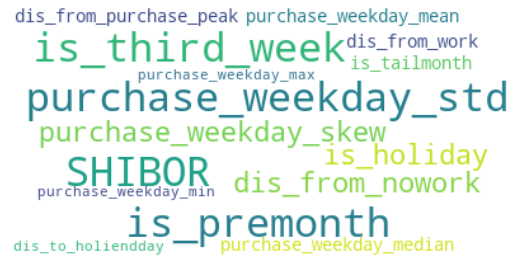

In [281]:
draw_cloud(tree_important_purchase)

### (5) Select the features with high permutation importance


In [282]:
model = LinearRegression()
train, test = split_data_underline(feature.dropna())
model.fit(train[features].drop(labels+['date'], axis=1), train['total_purchase_amt'])
perm = PermutationImportance(model, random_state=42).fit(test[features].drop(labels+['date'], axis=1), test['total_purchase_amt'])
liner_important_purchase = pd.DataFrame(np.abs(perm.feature_importances_), [x for x in features if x not in labels + date_indexs + ['date']]).reset_index()
eli5.show_weights(perm, feature_names=list(str(x) for x in features if x not in labels + ['date']))


Weight,Feature
0.6340 ± 0.4901,purchase_weekday_mean
0.5749 ± 0.5577,dis_to_work
0.3463 ± 0.1209,dis_from_purchase_valley
0.3416 ± 0.1587,dis_from_purchase_peak
0.3160 ± 0.2357,dis_to_nowork
0.1954 ± 0.1354,is_worked_yestday
0.1499 ± 0.1453,purchase_weekday_median
0.1454 ± 0.4254,purchase_weekday_min
0.0907 ± 0.2695,purchase_weekday_max
0.0761 ± 0.1276,is_third_week


In [283]:
liner_important_purchase = liner_important_purchase.sort_values(0, ascending=False).reset_index(drop=True)
liner_important_purchase = list(liner_important_purchase[:15]['index'])


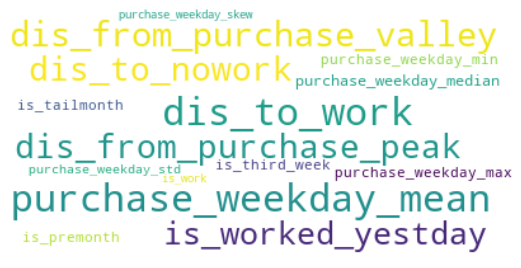

In [284]:
draw_cloud(liner_important_purchase)

### (6) Get the intersection of these two selection method

In [285]:
winer_features_purchase = list(set(tree_important_purchase)\
                     & set(liner_important_purchase))

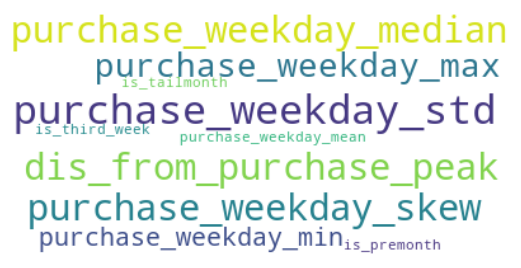

In [286]:
draw_cloud(winer_features_purchase)

In [287]:
feature[["date"]+labels+winer_features_purchase].to_csv("redeem_forecast.csv")

## Part 2 Forecast


In [ ]:
from typing import *
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1024)

In [ ]:
# Split the data
# Choose April as testset

def split_data_underline(data: pd.DataFrame)->pd.DataFrame:
    trainset = data[(datetime.date(2014,5,1) <= data['date']) & (data['date'] < datetime.date(2014,9,1))]
    testset = data[(datetime.date(2014,4,1) <= data['date']) & (data['date'] < datetime.date(2014,5,1))]
    return trainset, testset

def split_data_online(data: pd.DataFrame)->pd.DataFrame:
    trainset = data[(datetime.date(2014,4,1) <= data['date']) & (data['date'] < datetime.date(2014,9,1))]
    testset = data[(datetime.date(2014,9,1) <= data['date']) & (data['date'] < datetime.date(2014,10,1))]
    return trainset, testset

# Score function

def AE(y: Iterable, yhat: Iterable)->Iterable:
    return np.abs(y - yhat) / np.abs(y)

def total_AE(purchasehat: Iterable, redeemhat: Iterable, purchase: Iterable, redeem: Iterable, h: int = 0.3)->Iterable:
    return sum(map(lambda x : np.exp(-x/h)*10, AE(purchase, purchasehat))) * 0.45 + sum(map(lambda x : np.exp(-x/h)*10, AE(redeem, redeemhat))) * 0.55

# Evaluate the model for different time interval

def week_evalution_single(data: pd.DataFrame, model: object, types: str)->pd.DataFrame:
    results = []
    a_month = relativedelta(months=1)
    for i in [datetime.date(2014, 8, 1), datetime.date(2014, 7, 25), datetime.date(2014, 7, 18), datetime.date(2014, 7, 11), 
          datetime.date(2014, 7, 4), datetime.date(2014, 6, 27), datetime.date(2014, 6,20)]:
        trainset = data[(i - 4 * a_month <= data['date']) & (data['date'] < i)]
        testset = data[(i <= data['date']) & (data['date'] < i + a_month)]
        if len(testset) == 0 or len(trainset) == 0:
            i = datetime.date(2014, 4, 20)
            trainset = data[(i - 4 * a_month <= data['date']) & (data['date'] < i)]
            testset = data[(i <= data['date']) & (data['date'] < datetime.date(2014, 9, 1))]
        feature = [x for x in trainset.columns if x not in ['total_purchase_amt','total_redeem_amt','date']]
        
        model.fit(X=trainset[feature], y=trainset['total_' + types + '_amt'])
        result_lr = model.predict(testset[feature])
        
        h = 0.3
        results.append(sum(AE(testset['total_' + types + '_amt'], result_lr).apply(lambda x : np.exp(-x/h))*10))
    return pd.DataFrame(results)

# Output the Score Table

def draw_eva_table(df: pd.DataFrame)->pd.DataFrame:
    rest = df.copy()
    rest['interval'] = [datetime.date(2014, 8, 1), datetime.date(2014, 7, 25), datetime.date(2014, 7, 18), datetime.date(2014, 7, 11), 
          datetime.date(2014, 7, 4), datetime.date(2014, 6, 27), datetime.date(2014, 6,20)]
    return rest


# Visualization

def visual(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame)->None:
    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'], result_purchase_lr, label='predicted_purchase')
    plt.plot(testset['date'], testset['total_purchase_amt'], label='real_purchase')

    plt.legend(loc='best')
    plt.title("The distribution of real and predict purchase")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.show()
    fig = plt.figure(figsize=(10,4))
    sns.barplot(testset['date'].dt.day ,result_purchase_lr - testset['total_purchase_amt'])

    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'], result_redeem_lr, label='predicted_redeem')
    plt.plot(testset['date'], testset['total_redeem_amt'], label='real_redeem')

    plt.legend(loc='best')
    plt.title("The distribution of real and predict redeem")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.show()
    fig = plt.figure(figsize=(10,4))
    sns.barplot(testset['date'].dt.day ,result_redeem_lr - testset['total_redeem_amt'])
    
    
# Feature extract outline

def feature_extract(data: pd.DataFrame, model: object, types: str)->Tuple[List[str], List[float]]:
    features = [x for x in data.columns if x not in labels + ['date']]
    random.shuffle(features)
    results = []
    score = -1
    for i in features:
        score_update = np.mean(week_evalution_single(data[results + [i] + labels + ['date']], model, types))
        if score_update > score:
            score = score_update
            results.append(i)
    return results, score
    
def robust_feature_extract(data: pd.DataFrame, model: object, types: str):
    results = []
    score = -1
    for i in range(10):
        results_update, score_update = feature_extract(data, model, types)
        if score_update > score:
            score = score_update
            results = results_update
        print(results_update, score_update)
    return results

# Define AIC,BIC

def AIC(L: Iterable, delta: float, n_features: int):
    return L * np.log10(delta) + 2 * (n_features + 1)
def AIC(L: Iterable, delta: float, n_features: int):
    return L * np.log10(delta) + (n_features + 1) * np.log10(L)


# Use AIC for model combination
def feature_extract_AIC(data: pd.DataFrame, model: object, types: str)->Tuple[List[str], float]:
    features = [x for x in data.columns if x not in labels + ['date']]
    random.shuffle(features)
    results = []
    test_score = 1e9
    train_score = 0
    for i in features:
        test_score_update = np.mean(week_evalution_single(data[results + [i] + labels + ['date']], model, types)[0])
        if test_score_update < test_score:
            test_score = test_score_update
            results.append(i)
            
    trainset, testset = split_data_underline(data)
    feature = results
    model.fit(X=trainset[feature], y=trainset['total_' + types + '_amt'])
    train_result_lr = model.predict(trainset[feature])
    delta = mean_squared_error(train_result_lr, trainset['total_' + types + '_amt'])
    #delta = np.sum(AE(trainset['total_' + types + '_amt'], train_result_lr).apply(lambda x : np.exp(-x/0.1))*10)
    return results, AIC(len(trainset), delta, len(feature))

def multi_model(data: pd.DataFrame, model: object, types: str)->Tuple[List[List[str]], float]:
    features = []
    weights = []
    for i in range(100):
        results_update, score_update = feature_extract_AIC(data, model, types)
        features.append(results_update)
        weights.append(score_update)
    avg = np.mean(weights)
    weights = [x - avg for x in weights]
    weights = [np.power((-1 * x / 2), 10) for x in weights]
    summ = np.sum(weights)
    weights = [x / summ for x in weights]
    return features, weights


#  Online result
def generate_online_result(df: pd.DataFrame, feature: Iterable, model = RandomForestRegressor(), target:str = 'total_purchase_amt')->Iterable:
    trainset, testset = split_data_online(df)
    model.fit(X=trainset[feature], y=trainset[target])
    result_purchase_lr = model.predict(testset[feature])
    return result_purchase_lr


# Underline result

def generate_under_result(df: pd.DataFrame, feature: Iterable, model = RandomForestRegressor(), target:str = 'total_purchase_amt')->Iterable:
    trainset, testset = split_data_underline(df)
    model.fit(X=trainset[feature], y=trainset[target])
    result_purchase_lr = model.predict(testset[feature])
    return result_purchase_lr


# Normalize Upload File
def normalize_upload_file(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame)->pd.DataFrame:
    testset['total_purchase_amt'] = result_purchase_lr
    testset['total_redeem_amt'] = result_redeem_lr
    online_upload = testset[['date','total_purchase_amt','total_redeem_amt']]
    online_upload['date'] = online_upload['date'].astype(str)
    online_upload['date'] = online_upload['date'].str.replace('-','')
    return online_upload



# Visualization for result
def draw_result(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame):
    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'].dt.day, result_purchase_lr, label='online_purchase')
    plt.plot(testset['date'].dt.day, result_redeem_lr, label='online_redeem')

    plt.legend(loc='best')
    plt.title("The predict values")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    
    
# DataFrame Add
def add_two_df(df1, df2, features = None, left_a = 0.45, right_a = 0.55):
    data = df1.copy()
    if not features:
        features = [x for x in data.columns if x != 'interval']
    for i in features:
        data[i] = (data[i] * left_a + df2[i] * right_a)
    return data


# DataFrame Multiply
def scale_df(df1, features = None, eta = 1):
    data = df1.copy()
    if not features:
        features = [x for x in data.columns if x != 'interval']
    for i in features:
        data[i] *= eta
    return data

## 2.1 Modeling and test

In [1]:
data = pd.read_csv('Dataset/feature-all2.csv')
data['date'] = pd.to_datetime(data['date'])
trainset, testset = split_data_underline(data)
result_purchase_lr = generate_under_result(data, [x for x in data.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], target='total_purchase_amt')
result_redeem_lr = generate_under_result(data, [x for x in data.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], target='total_redeem_amt')

UsageError: Line magic function `%nbmerge` not found.


### (1) predict for the test set


In [ ]:
temp = total_AE(result_purchase_lr, result_redeem_lr, testset['total_purchase_amt'], testset['total_redeem_amt'])
print(temp)
for model in [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), MLPRegressor(solver='lbfgs'), xgb.XGBRegressor(objective='reg:squarederror')]:
    result_purchase_lr = generate_under_result(data, [x for x in data.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], model,target='total_purchase_amt')
    result_redeem_lr = generate_under_result(data, [x for x in data.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], model,target='total_redeem_amt')
    print(repr(model).split('(')[0])
    print(total_AE(result_purchase_lr, result_redeem_lr, testset['total_purchase_amt'], testset['total_redeem_amt']))

### (2) Test for different intervals


In [ ]:
draw_eva_table(week_evalution_single(data, model=RandomForestRegressor(), types = 'purchase'))

In [ ]:
draw_eva_table(week_evalution_single(data, RandomForestRegressor(), 'redeem'))

### (3) April predicted and real

In [3]:
visual(result_purchase_lr, result_redeem_lr, testset)

NameError: name 'visual' is not defined

### (4) Online result

In [ ]:
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [ ]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('result-all2.csv',index=False,header=None)

## 2.2 Multi models comparison

In [ ]:
def multi_model_eva(data, types:str = 'purchase'):
    results = pd.DataFrame()
    for model in [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), MLPRegressor(solver='lbfgs'), xgb.XGBRegressor(objective='reg:squarederror')]:
        if results.empty:
            results = draw_eva_table(week_evalution_single(data, model, types)).rename(columns={0: repr(model).split('(')[0]})
        else:
            results = pd.merge(results, \
                               draw_eva_table(week_evalution_single(data, model, types)).rename(columns={0: repr(model).split('(')[0]}), on='interval')
    results = results[['interval'] + [x for x in results.columns if x != 'interval']]
    return results

In [ ]:
add_two_df(multi_model_eva(data, 'purchase'), multi_model_eva(data, 'redeem'))

### (2)Use different features

In [ ]:
data_purchase = pd.read_csv('Dataset/purchase_feature.csv')
data_purchase['date'] = pd.to_datetime(data_purchase['date'])
data_redeem = pd.read_csv('Dataset/redeem_feature.csv')
data_redeem['date'] = pd.to_datetime(data_redeem['date'])
trainset_purchase, testset_purchase = split_data_underline(data_purchase)
result_purchase_lr = generate_under_result(data_purchase, [x for x in data_purchase.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_purchase_amt')
trainset_redeem, testset_redeem = split_data_underline(data_redeem)
result_redeem_lr = generate_under_result(data_redeem, [x for x in data_redeem.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_redeem_amt')
total_AE(result_purchase_lr, result_redeem_lr, testset_purchase['total_purchase_amt'], testset_redeem['total_redeem_amt'])


In [ ]:
for model in [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), MLPRegressor(solver='lbfgs'), xgb.XGBRegressor(objective='reg:squarederror')]:
    result_purchase_lr = generate_under_result(data_purchase, [x for x in data_purchase.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], model,target='total_purchase_amt')
    result_redeem_lr = generate_under_result(data_redeem, [x for x in data_redeem.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], model,target='total_redeem_amt')
    print(repr(model).split('(')[0])
    print(total_AE(result_purchase_lr, result_redeem_lr, testset_purchase['total_purchase_amt'], testset_redeem['total_redeem_amt']))
    trainset, testset = split_data_underline(data)
    visual(result_purchase_lr, result_redeem_lr, testset)

In [ ]:
trainset_purchase, testset_purchase = split_data_online(data_purchase)
trainset_redeem, testset_redeem = split_data_online(data_redeem)

for model in [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), MLPRegressor(solver='lbfgs'), xgb.XGBRegressor(objective='reg:squarederror')]:
    result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], model,target='total_purchase_amt')
    result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], model,target='total_redeem_amt')
    mm = repr(model).split('(')[0]
    normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv(mm+'.csv',index=False,header=None)
    
add_two_df(multi_model_eva(data_purchase, 'purchase'), multi_model_eva(data_redeem, 'redeem'))

### (3) April result predicted and real

In [ ]:
trainset, testset = split_data_underline(data)
visual(result_purchase_lr, result_redeem_lr, testset)
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_redeem_amt')

### (4)Online result


In [ ]:
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('difffeatures.csv',index=False,header=None)

### (5)MLP

In [ ]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            MLPRegressor(solver='lbfgs'),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          MLPRegressor(solver='lbfgs'),'total_redeem_amt')
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('MLP.csv',index=False,header=None)

### (6) XGBOOST

In [ ]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            xgb.XGBRegressor(objective='reg:squarederror'),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          xgb.XGBRegressor(objective='reg:squarederror'),'total_redeem_amt')
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('XGB.csv',index=False,header=None)

### (7) AIC means

In [ ]:
purchase_features, purchase_weight = multi_model(data_purchase, model=LinearRegression(), types = 'purchase')
redeem_features, redeem_weight = multi_model(data_redeem, model=LinearRegression(), types = 'redeem')

def eva_for_aic(data_purchase, purchase_features, purchase_weight):
    results = pd.DataFrame()
    for index, feature in enumerate(purchase_features):
        if results.empty:
            results = scale_df(multi_model_eva(data_purchase[['date'] + labels + feature], 'purchase'), 
                               eta = purchase_weight[index])
        else:
            results = add_two_df(results, multi_model_eva(data_purchase[['date'] + labels + feature], 'purchase')
                                 , left_a = 1,
                                 right_a = purchase_weight[index])
    return results
add_two_df(eva_for_aic(data_purchase, purchase_features, purchase_weight), 
           eva_for_aic(data_redeem, redeem_features, redeem_weight))